# Predictive Modelling

In [1]:
%store -r  df_model features_x features_y

In [12]:
# Data handling

import pandas as pd
import numpy as np

# Plotting

import matplotlib.pyplot as plt
import seaborn as sns

# Model creation and evalution

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

# RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor

# SupportVectorRegressor

from sklearn.svm import SVR

# XGBoost

import xgboost as xgb
from xgboost import plot_importance

# NeuralProphet

from neuralprophet import NeuralProphet

# Tensorflow

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Lambda, Embedding, LSTM
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

In [3]:
# Changing sales = 0 to np.nan and applying a log-function to the target 'sales'

df_model.loc[df_model['is_train'] == 1, 'saleslog'] = np.log(1+df_model.loc[df_model['is_train'] == 1]['sales'])

In [4]:
# Train Test Split

data = df_model.loc[(df_model['is_train'] == 1)]
x_train, x_test, y_train, y_test = train_test_split(data[features_x], 
                                                    data[features_y], 
                                                    test_size=0.2, 
                                                    random_state=3)

In [5]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(675470, 21) (675470, 1) (168868, 21) (168868, 1)


## XGBoost

XGBoost is an algorithm which uses an ensemble of weak predictors to boost its accuracy.

In [6]:
# XGBoost uses a so called 'DMatrix' as input

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

num_round = 20000
evallist = [(dtrain, 'train'), (dtest, 'test')]

param = {'max_depth': 9,
         'eta': 0.01,
         'subsample': 0.75,
         'colsample_bytree': 0.6, 
         'objective': 'reg:squarederror',}

plst = list(param.items())

In [7]:
# Function to evaluate root mean percentage error

def ToWeight(y):
    '''
    weight calculation
    
    '''
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    '''
    calculates the root mean square percentage error based on yhat and real y value
    
    '''
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    '''
    RMPSE calculation during training for XGBoost
    
    '''
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

The XGBoost model will train for an arbitrarily large number of iterations, until the chosen metric does not improve for 100 iterations in succession. 

The chosen evaluation metric is RMSPE.

In [8]:
model_xgb = xgb.train(plst, dtrain, num_round, evallist,
                  feval=rmspe_xg, verbose_eval=2500, early_stopping_rounds=100)

[0]	train-rmse:8.18560	train-rmspe:0.99986	test-rmse:8.18785	test-rmspe:0.99986
[2500]	train-rmse:0.10063	train-rmspe:0.14114	test-rmse:0.10613	test-rmspe:0.11973
[5000]	train-rmse:0.08618	train-rmspe:0.10630	test-rmse:0.09606	test-rmspe:0.10987
[7500]	train-rmse:0.07825	train-rmspe:0.08944	test-rmse:0.09204	test-rmspe:0.10596
[10000]	train-rmse:0.07266	train-rmspe:0.07857	test-rmse:0.09001	test-rmspe:0.10379
[12500]	train-rmse:0.06838	train-rmspe:0.07213	test-rmse:0.08886	test-rmspe:0.10257
[15000]	train-rmse:0.06490	train-rmspe:0.06748	test-rmse:0.08816	test-rmspe:0.10181
[17500]	train-rmse:0.06196	train-rmspe:0.06392	test-rmse:0.08772	test-rmspe:0.10135
[17975]	train-rmse:0.06144	train-rmspe:0.06327	test-rmse:0.08766	test-rmspe:0.10126


The trained model is used to predict the provided unseen test-data. 

To submit the model result, the prediction needs to be formatted into a '.csv' file and uploaded to the challenge site.

In [10]:
# Make a submission dataframe to test RMSPE for unseen test-data (test.csv)

submit_xgb = df_model.loc[df_model['is_train'] == 0]
dsubmit_xgb = xgb.DMatrix(submit_xgb[features_x])
predictions_xgb = model_xgb.predict(dsubmit_xgb)

df_predictions = submit_xgb['id'].reset_index()
df_predictions['Id'] = df_predictions['id'].astype('int')
df_predictions['Sales'] = (np.exp(predictions_xgb) - 1) * 0.985 #Scale Back

df_predictions.sort_values('Id', inplace=True)
df_predictions[['Id', 'Sales']].to_csv('submit_xgboost.csv', index=False)

<Figure size 1296x576 with 0 Axes>

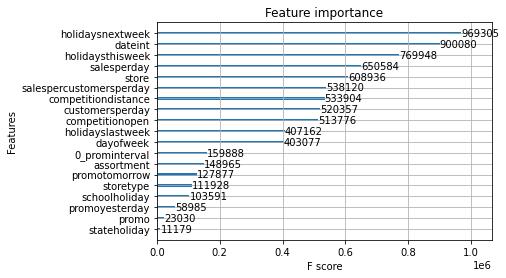

<Figure size 432x288 with 0 Axes>

In [14]:
# Print Feature Importance

plt.figure(figsize=(18,8))

plot_importance(model_xgb)
plt.show()
plt.savefig('xgboost_feature_importance.png')

In [15]:
# Save dataframes on disk

df.to_csv('dataframe_raw', index=False)
df_model.to_csv('dataframe_raw_model1', index=False)
data.to_csv('dataframe_modeldata1', index=False)

In [16]:
# To save model using pickle, uncomment this command

import pickle
filename = 'model_xgboost.sav'
#pickle.dump(model, open(filename, 'wb'))

# To load model, uncomment this command

#loaded_model = pickle.load(open("../model_xgboost.sav", 'rb'))

## Artificial Neural Networks

To assess the performance of the neural network, the predictions will be evaluated during training and validation.

In [17]:
def rmspe_val(y_true, y_pred):
    '''
    RMSPE calculus to validate evaluation metric about the model
    '''
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true), axis=0))[0]

def rmspe(y_true, y_pred):
    '''
    RMSPE calculus to use during training phase
    '''
    return K.sqrt(K.mean(K.square((y_true - y_pred) / y_true), axis=-1))

def rmse(y_true, y_pred):
    '''
    RMSE calculus to use during training phase
    '''
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

Two neural networks with different architectures are used:

 - First, a more traditional dense ANN with 3 hidden layers consisting of 512 nodes each.
After each hidden layer, a drop-out layer is incorporated to reduce overfitting during training face.

 - The second one is a LSTM model with 2 LSTM layers with 256 nodes each.

In [18]:
def ann_model():
    '''
    Create a neural network with Adam optimizer
    '''
    initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)

    model = Sequential()
    model.add(Dense(512, input_dim=x_train.shape[1], activation="relu", kernel_initializer=initializer))
    model.add(Dropout(0.4))
    model.add(Dense(512, input_dim=x_train.shape[1], activation="relu", kernel_initializer=initializer))
    model.add(Dropout(0.4))
    model.add(Dense(512, input_dim=x_train.shape[1], activation="relu", kernel_initializer=initializer))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation="linear", kernel_initializer=initializer))
    adam = Adam(lr=1e-3, decay=1e-3)

    # Compile model
    
    model.compile(loss="mean_squared_error", optimizer=adam, metrics=[rmse, rmspe])

    return model

In [19]:
def lstm_model():
    '''
    Create a LSTM with Adam optimizer
    '''
    initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)

    model = Sequential()
    model.add(Embedding(input_dim=x_train.shape[1], activation="relu", kernel_initializer=initializer))
    model.add(LSTM(256, input_dim=x_train.shape[1], activation="relu", kernel_initializer=initializer))
    model.add(LSTM(256, input_dim=x_train.shape[1], activation="relu", kernel_initializer=initializer))
    model.add(Dense(1, activation="linear", kernel_initializer=initializer))
    adam = Adam(lr=1e-3, decay=1e-3)

    # Compile model
    model.compile(loss="mean_squared_error", optimizer=adam, metrics=[rmse, rmspe])

    return model

In [20]:
# Hyperparameter for neural networks

batch_size = 512
nb_epoch = 300

adam = Adam(learning_rate = 0.001, decay=0.001)

model_tf = ann_model()
#model_lstm = lstm_model

model_tf.summary()
#model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               11264     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5

2021-08-10 09:08:58.243088: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-10 09:08:58.244187: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-10 09:08:58.244618: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (FLK-PC): /proc/driver/nvidia/version does not exist
2021-08-10 09:08:58.251847: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/buroez/.pyenv/versions/3.8.5/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:

During training evaluation, if the model improves itself during an epoch, the weights are saved in a log-file.

Furthermore, if the model does not improve the loss-function after 50 iterations during an epoch, training will be stopped early.

In [21]:
filepath="weights_rossmann.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min')
callbacks_list = [checkpoint, early_stopping]

log = model_tf.fit(x_train, y_train,
          validation_split=0.20, batch_size=batch_size, epochs=nb_epoch, shuffle=True, callbacks=callbacks_list)

2021-08-10 09:09:02.474086: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-10 09:09:02.485140: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz


Epoch 1/300
1056/1056 [==============================] - 12s 11ms/step - loss: 32010092544.0000 - rmse: 72855.0547 - rmspe: 5668.9800 - val_loss: 1902.2550 - val_rmse: 43.6140 - val_rmspe: 4.9455
Epoch 2/300
1056/1056 [==============================] - 12s 11ms/step - loss: 255238704.0000 - rmse: 15560.1426 - rmspe: 466.7111 - val_loss: 2007.0841 - val_rmse: 44.7995 - val_rmspe: 5.0725
Epoch 3/300
1056/1056 [==============================] - 12s 11ms/step - loss: 131331496.0000 - rmse: 11113.1738 - rmspe: 245.2760 - val_loss: 258.7308 - val_rmse: 16.0843 - val_rmspe: 1.7855
Epoch 4/300
1056/1056 [==============================] - 12s 11ms/step - loss: 88047664.0000 - rmse: 9036.3945 - rmspe: 169.6183 - val_loss: 2.5058 - val_rmse: 1.5825 - val_rmspe: 0.1581
Epoch 5/300
1056/1056 [==============================] - 12s 11ms/step - loss: 60808088.0000 - rmse: 7464.4243 - rmspe: 126.6442 - val_loss: 80.0017 - val_rmse: 8.9443 - val_rmspe: 1.0191
Epoch 6/300
1056/1056 [=====================

1056/1056 [==============================] - 12s 11ms/step - loss: 3245.2319 - rmse: 13.6506 - rmspe: 0.9605 - val_loss: 64.9266 - val_rmse: 8.0577 - val_rmspe: 0.9184
Epoch 46/300
1056/1056 [==============================] - 11s 11ms/step - loss: 2105.5625 - rmse: 14.2440 - rmspe: 0.9636 - val_loss: 64.5949 - val_rmse: 8.0371 - val_rmspe: 0.9161
Epoch 47/300
1056/1056 [==============================] - 11s 11ms/step - loss: 5914.3271 - rmse: 12.4771 - rmspe: 0.9498 - val_loss: 64.2736 - val_rmse: 8.0171 - val_rmspe: 0.9138
Epoch 48/300
1056/1056 [==============================] - 11s 11ms/step - loss: 699.0724 - rmse: 11.2586 - rmspe: 0.9407 - val_loss: 63.9595 - val_rmse: 7.9974 - val_rmspe: 0.9115
Epoch 49/300
1056/1056 [==============================] - 12s 11ms/step - loss: 1283.7341 - rmse: 10.6654 - rmspe: 0.9311 - val_loss: 63.6453 - val_rmse: 7.9778 - val_rmspe: 0.9093
Epoch 50/300
1056/1056 [==============================] - 11s 11ms/step - loss: 1354.8943 - rmse: 11.5091 - r

The DNN trained for 45,5 minutes, while the LSTM-Network took over 6 hours to train.

In [22]:
# Make a submission dataframe

submit_ann = df_model.loc[df_model['is_train'] == 0]
predictions_ann = model_tf.predict(submit_ann[features_x])

df_predictions = submit_ann['id'].reset_index()
df_predictions['Id'] = df_predictions['id'].astype('int')
df_predictions['Sales'] = predictions_ann

df_predictions.sort_values('Id', inplace=True)
df_predictions[['Id', 'Sales']].to_csv('submit_ANN.csv', index=False)

## Support Vector Regressor

Support Vector Regressor calculates a hyperplane as a boundary line using support vectors. This boundary line is then used to make a prediction.

In [23]:
# Scale input and target

x_sca = StandardScaler()
y_sca = StandardScaler()

x_train = x_sca.fit_transform(x_train)
y_train = y_sca.fit_transform(y_train)
y_train = y_train.ravel() # dimension reduction


In [24]:
# Train the SVR model using a linear kernel

model_svr = SVR(kernel='linear', C=100, gamma='auto')
model_svr.fit(x_train, y_train)

In [25]:
# Evalutate training of model

y_pred = svr.predict(x_test)
rmspe(y_pred, y_test)

In [26]:
# Make a submission dataframe

submit_svr = df_model.loc[df_model['is_train'] == 0]
predictions_svr = model_svr.predict(submit_svr)

df_predictions = submit_svr['id'].reset_index()
df_predictions['Id'] = df_predictions['id'].astype('int')
df_predictions['Sales'] = (np.exp(predictions_svr) - 1) * 0.985 #Scale Back

df_predictions.sort_values('Id', inplace=True)
df_predictions[['Id', 'Sales']].to_csv('submit_svr.csv', index=False)

## Random Forest Regressor

RandomForestRegressor is a supervised method that uses an ensemble of decision-trees to make a prediction.

In [27]:
# Hyperparameters to set no. of decision trees, the depth, leaf-seperation and aggregation method

rfr= RandomForestRegressor(n_estimators=100,
                          criterion="mse",
                          max_depth=5,
                          min_samples_split=2,
                          min_samples_leaf=1,
                          min_weight_fraction_leaf=0.0,
                          max_features="auto",
                          max_leaf_nodes=None,
                          min_impurity_decrease=0.0,
                          min_impurity_split=None,
                          bootstrap=True,
                          oob_score=False,
                          random_state=70,
                
                          )

In [28]:
# Train model

y_train = y_train.values.reshape(-1,)   # dimension reduction
model_rfr = rfr.fit(x_train,y_train)

In [29]:
x_test.isnull().sum()

holidaysnextweek           0
open                       0
assortment                 0
holidayslastweek           0
stateholiday               0
competitionopen            0
holidaysthisweek           0
salesperday                0
promotomorrow              0
promoyesterday             1
dayofweek                  0
store                      0
schoolholiday              0
0_prominterval             0
storetype                  0
dateint                    0
customersperday            0
competitiondistance        0
promosince                 0
promo                      0
salespercustomersperday    0
dtype: int64

In [30]:
# Impute missing value with out of range value

x_test.fillna(-999, inplace=True)
y_hat_rfr = model_rfr.predict(x_test)

In [31]:
# Change to numpy-float datatype and reduce dimension of y

y_hat_rfr = y_hat_rfr.astype(np.float64)
y_test_values = y_test.values.reshape(-1,)

In [32]:
# Evaluate training of model
rmspe(y_hat_rfr,y_test_values)

<tf.Tensor: shape=(), dtype=float64, numpy=0.024696594156846018>

In [33]:
# Make a submission dataframe 

#submit_rfr = df_model.loc[df_model['is_train'] == 0]
#submit_rfr.fillna(-999, inplace=True)
#predictions_rfr = model_rfr.predict(submit_rfr[features_x])

#df_predictions = submit_rfr['id'].reset_index()
#df_predictions['Id'] = df_predictions['id'].astype('int')
#df_predictions['Sales'] = (np.exp(predictions_rfr) - 1) * 0.985 #Scale Back

#df_predictions.sort_values('Id', inplace=True)
#df_predictions[['Id', 'Sales']].to_csv('submit_rfr.csv', index=False)

# NeuralProphet

NeuralProphet is based on neural networks and optimized for time series data.

It makes a prediction based on  the historical development of observations.

In [34]:
# NeuralProphet only takes the timeseries and target feature as input

df_prophet = df_model.drop(["saleslog","id","is_train","assortment", "competitiondistance","competitionopen","salespercustomersperday","stateholiday","storetype", \
                         "dayofyear","day","month","year","promosince", "0_prominterval","dateint","promotomorrow","promoyesterday", \
                         "schoolholiday","promo","open","customers","dayofweek","store","salesperday","customersperday","holidaysnextweek","holidaysthisweek","holidayslastweek"],axis=1)

In [35]:
df_prophet.columns = ["y","ds"]
df_prophet = df_prophet[["ds","y"]]
df_prophet = df_prophet.sort_index(ascending = False)

In [36]:
# NaNs must be dropped

df_prophet.dropna(subset= ["y"], inplace=True)


In [37]:
df_prophet

,ds,y
844337,2013-01-01,5961.0
844336,2013-01-01,4491.0
844335,2013-01-01,5035.0
844334,2013-01-01,10765.0
844333,2013-01-01,3375.0
...,...,...
4,2015-07-31,4822.0
3,2015-07-31,13995.0
2,2015-07-31,8314.0
1,2015-07-31,6064.0


In [38]:
model_np = NeuralProphet(changepoints_range= 0.95,daily_seasonality=True, learning_rate= 0.05,
                   num_hidden_layers= 30, epochs= 10, batch_size= 256,n_changepoints=100)




In [39]:
metric_np = model_np.fit(df_prophet, freq="D")



Epoch[10/10]: 100%|██████████████████████████████████████| 10/10 [02:51<00:00, 17.13s/it, SmoothL1Loss=0.0244, MAE=2.19e+3, RegLoss=0]


In [40]:
future = model_np.make_future_dataframe(df_prophet, periods=48,n_historic_predictions=168820)


In [41]:
forecast = model_np.predict(future)

In [42]:
y_hat_np = forecast["yhat1"]

In [43]:
rmspe(y_hat_np, y_test_values)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9987530143235122>

In [44]:
forecast

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,season_daily
0,2015-01-30,8910.0,6986.784180,-1923.21582,661.809692,-437.812622,-18.099194,6780.88623
1,2015-01-30,6670.0,6986.784180,316.78418,661.809692,-437.812622,-18.099194,6780.88623
2,2015-01-30,5997.0,6986.784180,989.78418,661.809692,-437.812622,-18.099194,6780.88623
3,2015-01-30,6535.0,6986.784180,451.78418,661.809692,-437.812622,-18.099194,6780.88623
4,2015-01-30,8350.0,6986.784180,-1363.21582,661.809692,-437.812622,-18.099194,6780.88623
...,...,...,...,...,...,...,...,...
168863,2015-09-13,NaN,8033.434570,NaN,925.436523,-535.809814,862.921936,6780.88623
168864,2015-09-14,NaN,8306.729492,NaN,929.642090,-521.072205,1117.274292,6780.88623
168865,2015-09-15,NaN,7183.494141,NaN,933.847168,-504.603973,-26.634510,6780.88623
168866,2015-09-16,NaN,6878.234863,NaN,938.052734,-486.602325,-354.101166,6780.88623


In [45]:
# Make a submission dataframe to test RMSPE for unseen test-data (test.csv)

submit = df_model.loc[df_model['is_train'] == 0]

# Pre = mn.predict(future)

df_predictions = submit['id'].reset_index()
df_predictions['Id'] = df_predictions['id'].astype('int')
df_predictions['Sales'] = (np.exp(y_hat_np) - 1) * 0.985 #Scale Back

df_predictions.sort_values('Id', inplace=True)
df_predictions[['Id', 'Sales']].to_csv('submit_neuralprophet_01.csv', index=False)

/home/buroez/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


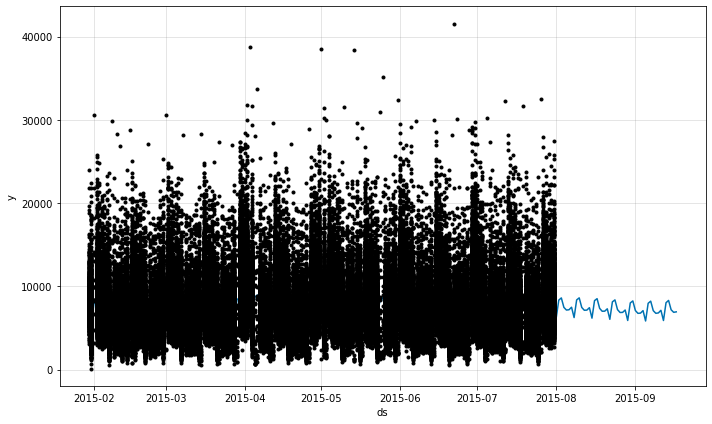

In [46]:
forecasts_plot = model_np.plot(forecast)


In [47]:
fig_comp = mn.plot_components(forecast)

NameError: name 'mn' is not defined

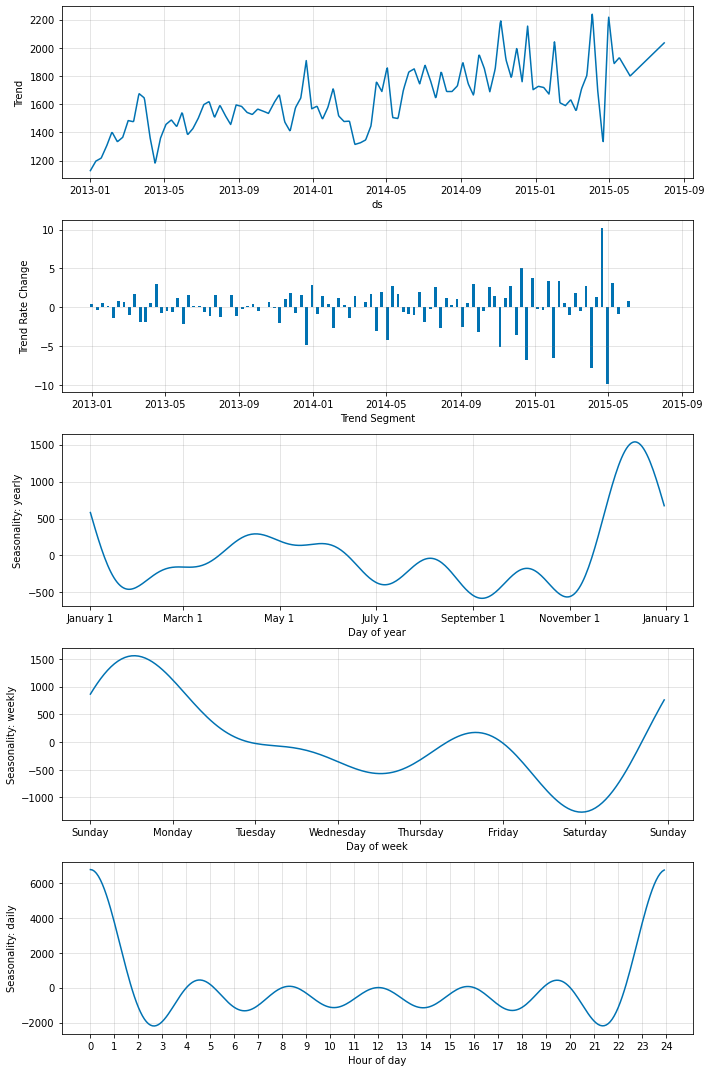

In [48]:
fig_param = model_np.plot_parameters()
